In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

2024-11-29 17:33:59.998916: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
file_path = "ibm.csv"
file_cleaned_path = "cleaned_ibm.csv"
data = pd.read_csv(file_path)

data_filtered = data[["Date", "Open", "High", "Low", "Volume", "Close"]].sort_values(by="Date")
data_cleaned = data_filtered.dropna()

data_cleaned.to_csv(file_cleaned_path, index=False)
data = pd.read_csv(file_cleaned_path)
data.head()

,Date,Open,High,Low,Volume,Close
0,1962-01-02 00:00:00-05:00,1.518550,1.518550,1.501487,407940,1.501487
1,1962-01-03 00:00:00-05:00,1.501487,1.514612,1.501487,305955,1.514612
2,1962-01-04 00:00:00-05:00,1.514613,1.514613,1.498863,274575,1.499519
3,1962-01-05 00:00:00-05:00,1.497551,1.497551,1.467363,384405,1.469988
4,1962-01-08 00:00:00-05:00,1.468675,1.468675,1.430613,572685,1.442425


In [3]:
data["Target"] = data["Close"].shift(-1)
data.head()

,Date,Open,High,Low,Volume,Close,Target
0,1962-01-02 00:00:00-05:00,1.518550,1.518550,1.501487,407940,1.501487,1.514612
1,1962-01-03 00:00:00-05:00,1.501487,1.514612,1.501487,305955,1.514612,1.499519
2,1962-01-04 00:00:00-05:00,1.514613,1.514613,1.498863,274575,1.499519,1.469988
3,1962-01-05 00:00:00-05:00,1.497551,1.497551,1.467363,384405,1.469988,1.442425
4,1962-01-08 00:00:00-05:00,1.468675,1.468675,1.430613,572685,1.442425,1.459488


In [4]:
final_data_row = data.tail(1)
data.drop(data.tail(1).index, inplace=True)
data.dropna(inplace=True)
final_data_row

,Date,Open,High,Low,Volume,Close,Target
15825,2024-11-13 00:00:00-05:00,209.5,211.410004,209.070099,2186158,210.669998,NaN


In [5]:
data.iloc[:, 1:].corr()['Target']

Open      0.999714
High      0.999765
Low       0.999767
Volume    0.133558
Close     0.999812
Target    1.000000
Name: Target, dtype: float64

In [6]:
# Features scaling
model_features = data.drop("Target", axis=1).drop("Date", axis=1)
model_target = data["Target"]

model_feature_scaler = MinMaxScaler()
model_feature_scaler.fit(model_features)
model_scaled_features = pd.DataFrame(model_feature_scaler.transform(model_features), columns=model_features.columns.tolist())

model_target_scaler = MinMaxScaler()
model_target_scaler.fit(model_target.values.reshape(-1,1))
model_scaled_target = pd.DataFrame(model_target_scaler.transform(model_target.values.reshape(-1,1)), columns=["Target"])

In [7]:
def create_dataset(X_data, y_data, t_steps):
    X, y = [], []
    for i in range(len(X_data) - t_steps):
        v = X_data.iloc[i:(i + t_steps)].values
        X.append(v)
        y.append(y_data.iloc[i + t_steps])
    return np.array(X), np.array(y)

In [8]:
t_steps = 60
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)
X.shape, y.shape

((15765, 60, 5), (15765, 1))

In [9]:
train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12612, 60, 5), (3153, 60, 5), (12612, 1), (3153, 1))

In [10]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

2024-11-29 14:06:47.628787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 151 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


(TensorShape([12612, 60, 5]),
 TensorShape([12612, 1]),
 TensorShape([3153, 60, 5]),
 TensorShape([3153, 1]))

In [11]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_step, features)
input_shape

(60, 5)

In [12]:
num_epochs = 30
batch_size = 64

rnn_model = Sequential([
    tf.keras.layers.SimpleRNN(units=50, return_sequences=True, input_shape=input_shape),
    tf.keras.layers.SimpleRNN(units=50),
    Dense(units=1)
])

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 50)            2800      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 7,901
Trainable params: 7,901
Non-trainable params: 0
_________________________________________________________________


In [13]:
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

history_rnn = rnn_model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/30


2024-11-29 14:07:00.069245: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x256c9cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-29 14:07:00.069343: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2024-11-29 14:07:00.077537: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-29 14:07:00.226227: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/198 [==============================] - 19s 77ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 2/30
198/198 [==============================] - 15s 73ms/step - loss: 8.8458e-05 - val_loss: 0.0012
Epoch 3/30
198/198 [==============================] - 15s 74ms/step - loss: 5.9826e-05 - val_loss: 9.3686e-04
Epoch 4/30
198/198 [==============================] - 15s 74ms/step - loss: 6.6225e-05 - val_loss: 7.1805e-04
Epoch 5/30
198/198 [==============================] - 14s 73ms/step - loss: 5.6417e-05 - val_loss: 6.5934e-04
Epoch 6/30
198/198 [==============================] - 14s 71ms/step - loss: 6.8215e-05 - val_loss: 0.0011
Epoch 7/30
198/198 [==============================] - 14s 70ms/step - loss: 3.8519e-05 - val_loss: 5.2862e-04
Epoch 8/30
198/198 [==============================] - 14s 73ms/step - loss: 5.4265e-05 - val_loss: 6.9015e-04
Epoch 9/30
198/198 [==============================] - 15s 74ms/step - loss: 4.4543e-05 - val_loss: 4.7048e-04
Epoch 10/30
198/198 [================

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

In [15]:
# Make predictions and evaluate RNN model
rnn_predictions = rnn_model.predict(X_test)

# Add dummy columns to match the original scaled data shape (5 columns)
dummy_columns = np.zeros((rnn_predictions.shape[0], 4))  # 4 dummy columns to match Open, High, Low, Volume
predicted_prices_scaled = np.concatenate((dummy_columns, rnn_predictions), axis=1)

# Apply inverse transformation to get back to original scale
predicted_prices = model_feature_scaler.inverse_transform(predicted_prices_scaled)[:, -1]  # Get only the Close column

# Similarly for actual prices
actual_prices_scaled = np.concatenate((dummy_columns, y_test.numpy().reshape(-1, 1)), axis=1)
actual_prices = model_feature_scaler.inverse_transform(actual_prices_scaled)[:, -1]


rnn_mse, rnn_rmse, rnn_mae = calculate_metrics(actual_prices, predicted_prices)
print(f'RNN Model - MSE: {rnn_mse:.4f}, RMSE: {rnn_rmse:.4f}, MAE: {rnn_mae:.4f}')

99/99 [==============================] - 1s 10ms/step
RNN Model - MSE: 9.8146, RMSE: 3.1328, MAE: 2.1952


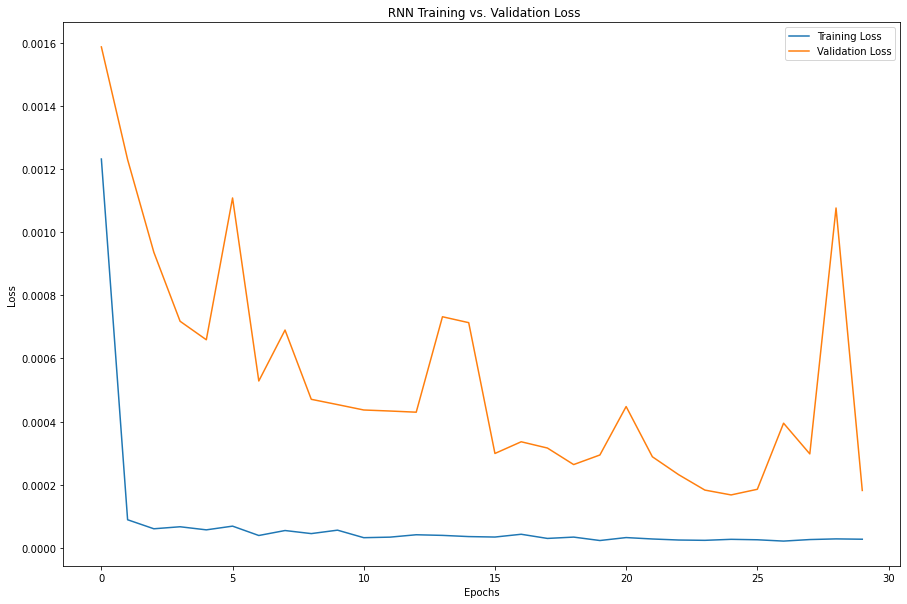

In [16]:
%matplotlib inline 

plt.figure(figsize=(15, 10))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title(' RNN Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

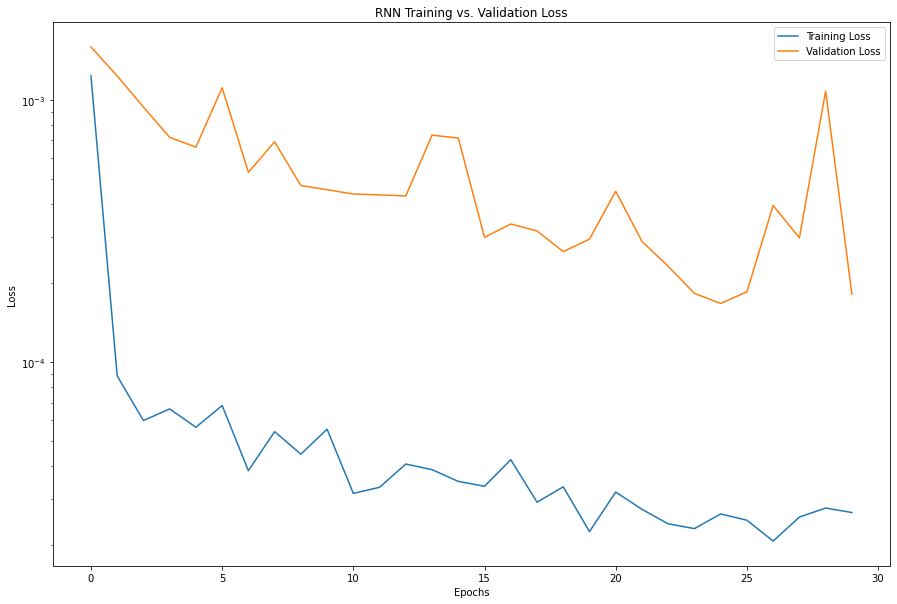

In [17]:
# plotting code with log scale

%matplotlib inline 

plt.figure(figsize=(15, 10))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('RNN Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # Setting the y-axis to logarithmic scale
plt.legend()
plt.show()

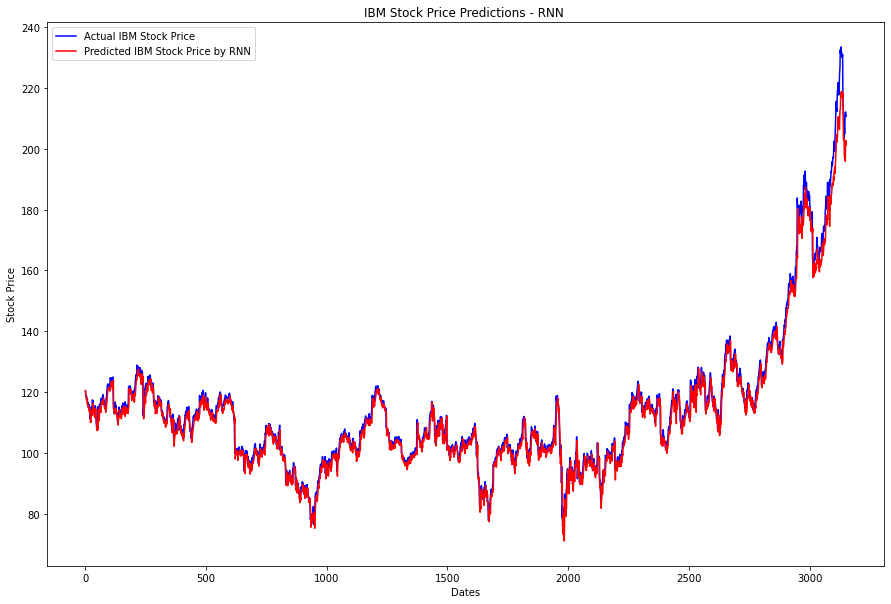

In [18]:
# predicted and actual price plot 

plt.figure(figsize=(15, 10))
plt.plot(actual_prices, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_prices, color="red", label="Predicted IBM Stock Price by RNN")
plt.title("IBM Stock Price Predictions - RNN ")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

## Now trying random search for hyperparameter optimization

In [21]:
import random
import numpy as np
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


param_ranges = {
    "units": (32, 256), 
    "batch_size": (16, 128),
    "learning_rate": (1e-5, 1e-2),
    "time_steps": (30, 120) }


n_samples = 20

def generate_random_params():
    units = random.randint(param_ranges["units"][0], param_ranges["units"][1])
    batch_size = random.randint(param_ranges["batch_size"][0], param_ranges["batch_size"][1])
    learning_rate = random.uniform(param_ranges["learning_rate"][0], param_ranges["learning_rate"][1])
    time_steps = random.randint(param_ranges["time_steps"][0], param_ranges["time_steps"][1])
    return units, batch_size, learning_rate, time_steps

def evaluate_model(units, batch_size, learning_rate, time_steps):

    global X_train, y_train, X_test, y_test
    X, y = create_dataset(model_scaled_features, model_scaled_target, time_steps)
    train_size = int(0.80 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]


    X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
    X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
    
    input_shape = (time_steps, X_train.shape[2])

    rnn_model = Sequential([
    tf.keras.layers.SimpleRNN(units=units, return_sequences=True, input_shape=input_shape),
    tf.keras.layers.SimpleRNN(units=units),
    Dense(units=1)])

    rnn_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)


    # Training model
    history = rnn_model.fit(
        X_train_tensor, y_train_tensor,
        epochs=10,
        batch_size=batch_size,
        validation_data=(X_test_tensor, y_test_tensor),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    val_loss = min(history.history['val_loss'])
    return val_loss

# Performing random search

# Number of random samples 
n_samples= 20 
best_params = None
best_loss = float("inf")

for i in range(n_samples):
    units, batch_size, learning_rate, time_steps = generate_random_params()

    # Log the parameters being tested
    print(f"\nTesting Hyperparameters: Units = {units}, Batch Size = {batch_size}, "
          f"Learning Rate = {learning_rate:.6f}, Time Steps = {time_steps}")
    
    # Evaluate the model
    val_loss = evaluate_model(units, batch_size, learning_rate, time_steps)
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")


    # Log the result
    print(f"Validation Loss: {val_loss:.6f}")

    # Update best parameters if the current loss is lower
    if val_loss < best_loss:
        best_loss = val_loss
        best_params = (units, batch_size, learning_rate, time_steps)

# Print the best hyperparameters and their validation loss
print(f"Best Parameters: Units = {best_params[0]} Batch Size = {best_params[1]}, "
      f"Learning Rate = {best_params[2]:.6f}, Time Steps (t_steps) = {best_params[3]}")
print(f"Best Validation Loss: {best_loss:.6f}")


Testing Hyperparameters: Units = 74, Batch Size = 90, Learning Rate = 0.003298, Time Steps = 67
Epoch 1/10
141/141 [==============================] - 13s 73ms/step - loss: 0.0129 - val_loss: 5.8167e-04 - lr: 0.0033
Epoch 2/10
141/141 [==============================] - 10s 72ms/step - loss: 7.9019e-05 - val_loss: 3.6668e-04 - lr: 0.0033
Epoch 3/10
141/141 [==============================] - 11s 76ms/step - loss: 1.9814e-04 - val_loss: 0.0022 - lr: 0.0033
Epoch 4/10
141/141 [==============================] - 10s 72ms/step - loss: 1.6007e-04 - val_loss: 4.8522e-04 - lr: 0.0033
Epoch 5/10
141/141 [==============================] - 10s 71ms/step - loss: 3.9401e-05 - val_loss: 3.2539e-04 - lr: 0.0016
Epoch 6/10
141/141 [==============================] - 10s 71ms/step - loss: 2.9919e-05 - val_loss: 2.2549e-04 - lr: 0.0016
Epoch 7/10
141/141 [==============================] - 10s 71ms/step - loss: 4.0199e-05 - val_loss: 2.2780e-04 - lr: 0.0016
Epoch 8/10
141/141 [==============================

## Now using these parameters to test RNN model again

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

t_steps = 98
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)

train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#converting into tensor 
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

input_shape = (X_train.shape[1], X_train.shape[2])

#batch size and no of epochs
num_epochs = 30
batch_size = 35

model_optimized = Sequential([
    tf.keras.layers.SimpleRNN(units=141, return_sequences=True, input_shape=input_shape),
    tf.keras.layers.SimpleRNN(units=141),
    Dense(units=1)])


model_optimized.compile(optimizer=Adam(learning_rate=0.001713), loss='mean_squared_error')

# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True
# )

# # Reduce learning rate when plateau is reached
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2,
#     patience=5,
#     min_lr=1e-5
# )

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)


history_rnn = model_optimized.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

2024-11-29 17:36:17.751880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 151 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Epoch 1/30


2024-11-29 17:36:20.608242: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x28863d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-29 17:36:20.608278: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2024-11-29 17:36:20.619407: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-29 17:36:20.760430: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


360/360 [==============================] - 40s 103ms/step - loss: 0.1278 - val_loss: 0.1441 - lr: 0.0017
Epoch 2/30
360/360 [==============================] - 38s 106ms/step - loss: 0.0083 - val_loss: 0.0632 - lr: 0.0017
Epoch 3/30
360/360 [==============================] - 38s 105ms/step - loss: 0.0029 - val_loss: 0.0492 - lr: 0.0017
Epoch 4/30
360/360 [==============================] - 37s 103ms/step - loss: 0.0016 - val_loss: 0.0218 - lr: 0.0017
Epoch 5/30
360/360 [==============================] - 38s 107ms/step - loss: 7.4627e-04 - val_loss: 0.0094 - lr: 0.0017
Epoch 6/30
360/360 [==============================] - 37s 103ms/step - loss: 2.9567e-04 - val_loss: 0.0046 - lr: 0.0017
Epoch 7/30
360/360 [==============================] - 36s 101ms/step - loss: 2.1638e-04 - val_loss: 0.0019 - lr: 0.0017
Epoch 8/30
360/360 [==============================] - 39s 108ms/step - loss: 1.9763e-04 - val_loss: 8.6054e-04 - lr: 0.0017
Epoch 9/30
360/360 [==============================] - 39s 107ms

## Again plotting the graphs based on new set of optimized hyperparameters

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

predictions = model_optimized.predict(X_test)

# Adding dummy columns to match the original scaled data shape (5 columns)
# 4 dummy columns to match Open, High, Low, Volume
dummy_columns = np.zeros((predictions.shape[0], 4))
predicted_prices_scaled = np.concatenate((dummy_columns, predictions), axis=1)

# Applying inverse transformation to get back to original scale
predicted_prices = model_feature_scaler.inverse_transform(predicted_prices_scaled)[:, -1]

# for actual prices
actual_prices_scaled = np.concatenate((dummy_columns, y_test.numpy().reshape(-1, 1)), axis=1)
actual_prices = model_feature_scaler.inverse_transform(actual_prices_scaled)[:, -1]

# Calculating metrics
lstm_mse, lstm_rmse, lstm_mae = calculate_metrics(actual_prices, predicted_prices)
print(f'RNN Model - MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}')

99/99 [==============================] - 2s 16ms/step
RNN Model - MSE: 19.9890, RMSE: 4.4709, MAE: 2.5553


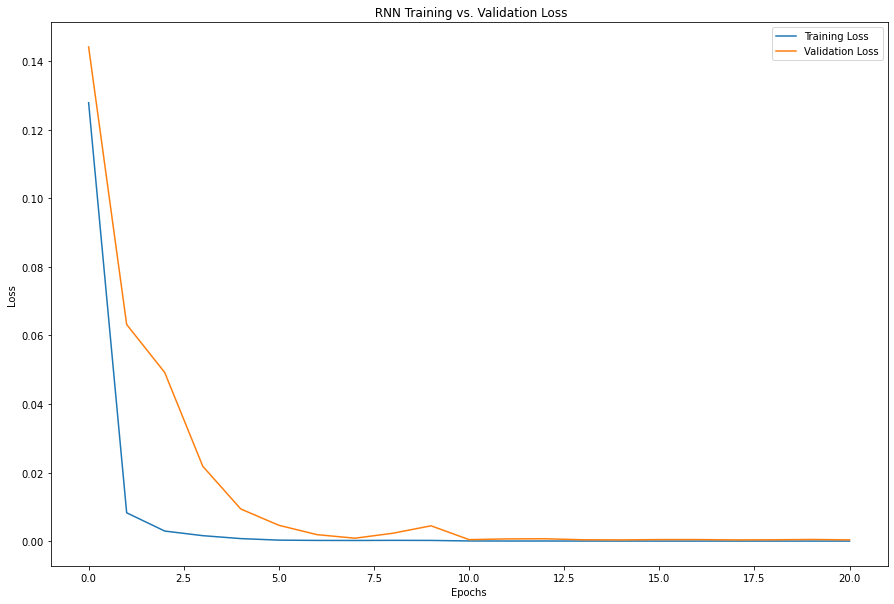

In [11]:
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title(' RNN Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

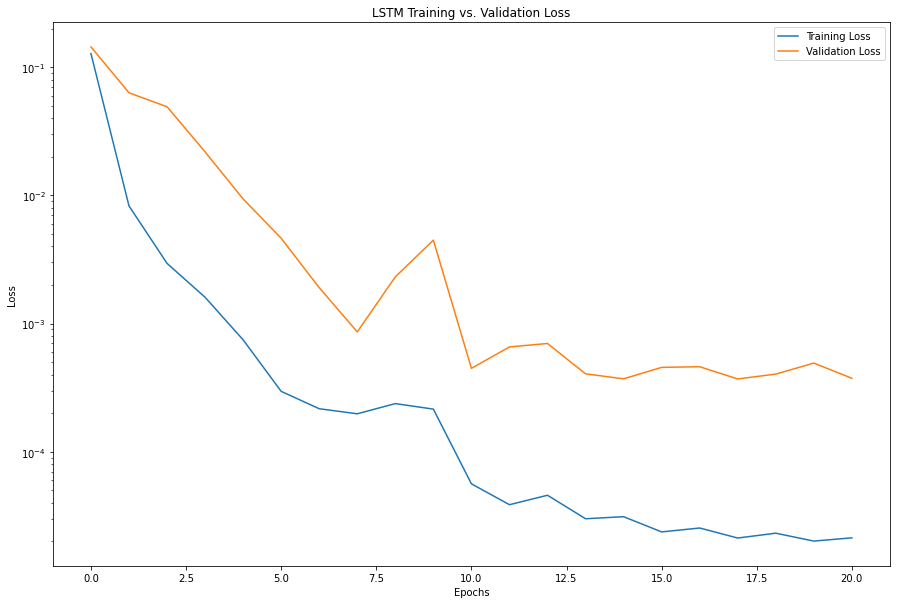

In [12]:
%matplotlib inline
# Your existing plotting code with log scale
plt.figure(figsize=(15, 10))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')  # Setting the y-axis to logarithmic scale

plt.legend()
plt.show()

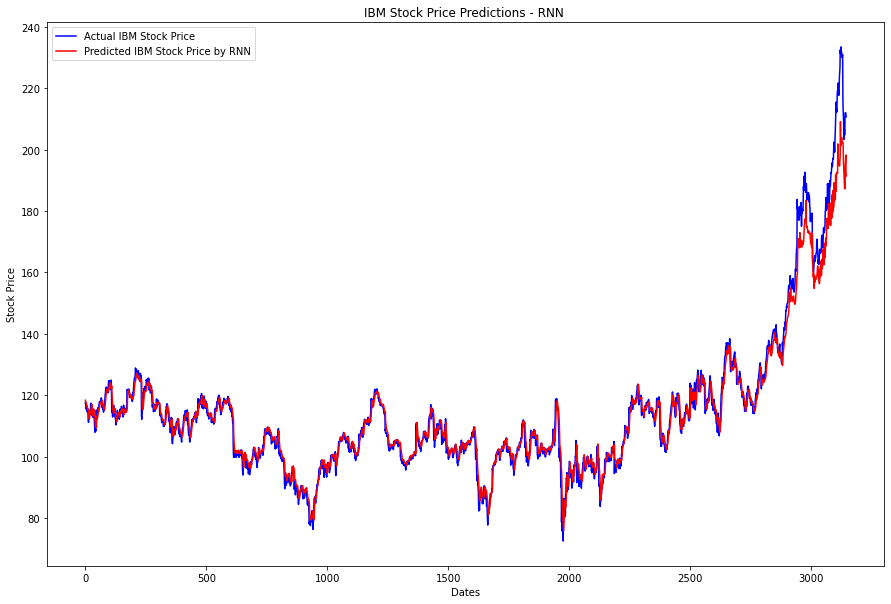

In [13]:
# predicted and actual price plot 

plt.figure(figsize=(15, 10))
plt.plot(actual_prices, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_prices, color="red", label="Predicted IBM Stock Price by RNN")
plt.title("IBM Stock Price Predictions - RNN ")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

### Using PSO for optimization

In [15]:
import random
import numpy as np
import pyswarm
from pyswarm import pso
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

param_ranges = {
    "units": (32, 256),       # Range for LSTM units
    "batch_size": (16, 128),       # Range for batch size
    "learning_rate": (1e-5, 1e-2), # Range for learning rate
    "t_steps": (30, 120)           # Range for sequence length
}

bounds = [
    param_ranges["units"],       # Bounds for LSTM units
    param_ranges["batch_size"],       # Bounds for batch size
    param_ranges["learning_rate"],    # Bounds for learning rate
    param_ranges["t_steps"]           # Bounds for sequence length
]

def objective_function(params):
    # Extract and round parameters
    units = int(params[0])  
    batch_size = int(params[1])
    learning_rate = float(params[2])
    t_steps = int(params[3])

    print(f"\nTrying Hyperparameters: Units = {units}, Batch Size = {batch_size}, "
          f"Learning Rate = {learning_rate:.6f}, Sequence Length (t_steps) = {t_steps}")

    # Update sequence length for data creation
    global X_train, y_train, X_test, y_test
    X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)
    train_size = int(0.80 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Convert to tensors
    X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
    X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
    
    input_shape = (t_steps, X_train.shape[2])

    # Define the new model architecture
    model = Sequential([
    tf.keras.layers.SimpleRNN(units=units, return_sequences=True, input_shape=input_shape),
    tf.keras.layers.SimpleRNN(units=units),
    Dense(units=1)])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)

    # Train the model
    history = model.fit(
        X_train_tensor, y_train_tensor,
        epochs=10,
        batch_size=batch_size,
        validation_data=(X_test_tensor, y_test_tensor),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Get validation loss
    val_loss = min(history.history['val_loss'])

    print(f"Validation Loss: {val_loss:.6f}")

    # Return the validation loss
    return val_loss

# Run PSO with the new model
best_params, best_loss = pso(
    objective_function,
    lb=[b[0] for b in bounds],  # Lower bounds
    ub=[b[1] for b in bounds],  # Upper bounds
    swarmsize=5,               # Number of particles
    maxiter=5,                 # Number of iterations
    debug=True                  # Enable logging
)

print(f"\nBest Parameters: Units = {int(best_params[0])}, Batch Size = {int(best_params[1])}, "
      f"Learning Rate = {best_params[2]:.6f}, Sequence Length (t_steps) = {int(best_params[3])}")
print(f"Best Validation Loss: {best_loss:.6f}")

No constraints given.

Trying Hyperparameters: Units = 165, Batch Size = 66, Learning Rate = 0.001337, Sequence Length (t_steps) = 80
Epoch 1/10
191/191 [==============================] - 20s 87ms/step - loss: 0.0938 - val_loss: 0.0529 - lr: 0.0013
Epoch 2/10
191/191 [==============================] - 16s 85ms/step - loss: 4.3886e-04 - val_loss: 2.3929e-04 - lr: 0.0013
Epoch 3/10
191/191 [==============================] - 17s 87ms/step - loss: 1.2679e-04 - val_loss: 2.8950e-04 - lr: 0.0013
Epoch 4/10
191/191 [==============================] - 17s 91ms/step - loss: 1.8529e-04 - val_loss: 2.4278e-04 - lr: 0.0013
Epoch 5/10
191/191 [==============================] - 17s 88ms/step - loss: 6.1393e-05 - val_loss: 3.8925e-04 - lr: 6.6840e-04
Validation Loss: 0.000239

Trying Hyperparameters: Units = 140, Batch Size = 48, Learning Rate = 0.000743, Sequence Length (t_steps) = 49
Epoch 1/10
263/263 [==============================] - 18s 58ms/step - loss: 0.0041 - val_loss: 2.2726e-04 - lr: 7.434

### Using PSO optimized set of hyperparameters on RNN model

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

t_steps = 64
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)

train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#converting into tensor
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

input_shape = (X_train.shape[1], X_train.shape[2])

#batch size and no of epochs
num_epochs = 30
batch_size = 99

model_optimized = Sequential([
    tf.keras.layers.SimpleRNN(units = 133, return_sequences=True, input_shape=input_shape),
    tf.keras.layers.SimpleRNN(units = 133 ),
    Dense(units=1)])

model_optimized.compile(optimizer=Adam(learning_rate=0.002217), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)

history_rnn = model_optimized.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

Epoch 1/30
128/128 [==============================] - 12s 72ms/step - loss: 0.0504 - val_loss: 8.7880e-04 - lr: 0.0022
Epoch 2/30
128/128 [==============================] - 9s 73ms/step - loss: 1.9724e-04 - val_loss: 0.0012 - lr: 0.0022
Epoch 3/30
128/128 [==============================] - 9s 72ms/step - loss: 1.7967e-04 - val_loss: 0.0014 - lr: 0.0022
Epoch 4/30
128/128 [==============================] - 9s 69ms/step - loss: 5.8913e-05 - val_loss: 5.9586e-04 - lr: 0.0011
Epoch 5/30
128/128 [==============================] - 9s 69ms/step - loss: 5.3653e-05 - val_loss: 4.1309e-04 - lr: 0.0011
Epoch 6/30
128/128 [==============================] - 8s 66ms/step - loss: 4.0808e-05 - val_loss: 3.4450e-04 - lr: 0.0011
Epoch 7/30
128/128 [==============================] - 9s 70ms/step - loss: 5.9149e-05 - val_loss: 4.6306e-04 - lr: 0.0011
Epoch 8/30
128/128 [==============================] - 9s 71ms/step - loss: 3.8509e-05 - val_loss: 4.2304e-04 - lr: 5.5425e-04
Epoch 9/30
128/128 [===========

### Plotting the graph based on optimized hyperparameter from PSO

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

In [26]:
# Make predictions and evaluate RNN model
rnn_predictions = model_optimized.predict(X_test)

# Add dummy columns to match the original scaled data shape (5 columns)
dummy_columns = np.zeros((rnn_predictions.shape[0], 4))  # 4 dummy columns to match Open, High, Low, Volume
predicted_prices_scaled = np.concatenate((dummy_columns, rnn_predictions), axis=1)

# Apply inverse transformation to get back to original scale
predicted_prices = model_feature_scaler.inverse_transform(predicted_prices_scaled)[:, -1]  # Get only the Close column

# Similarly for actual prices
actual_prices_scaled = np.concatenate((dummy_columns, y_test.numpy().reshape(-1, 1)), axis=1)
actual_prices = model_feature_scaler.inverse_transform(actual_prices_scaled)[:, -1]


rnn_mse, rnn_rmse, rnn_mae = calculate_metrics(actual_prices, predicted_prices)
print(f'RNN Model - MSE: {rnn_mse:.4f}, RMSE: {rnn_rmse:.4f}, MAE: {rnn_mae:.4f}')

99/99 [==============================] - 1s 11ms/step
RNN Model - MSE: 13.0310, RMSE: 3.6099, MAE: 2.4144


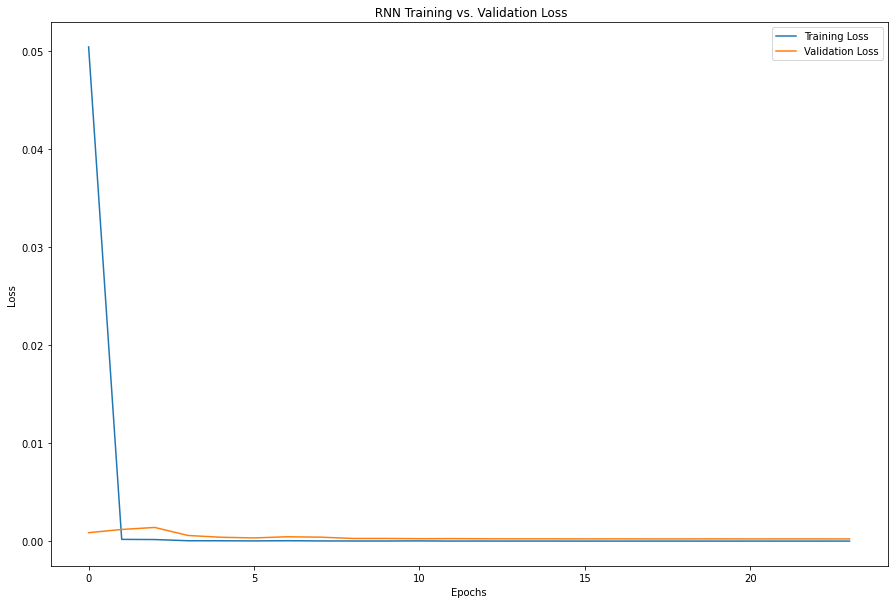

In [27]:
%matplotlib inline 

plt.figure(figsize=(15, 10))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title(' RNN Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

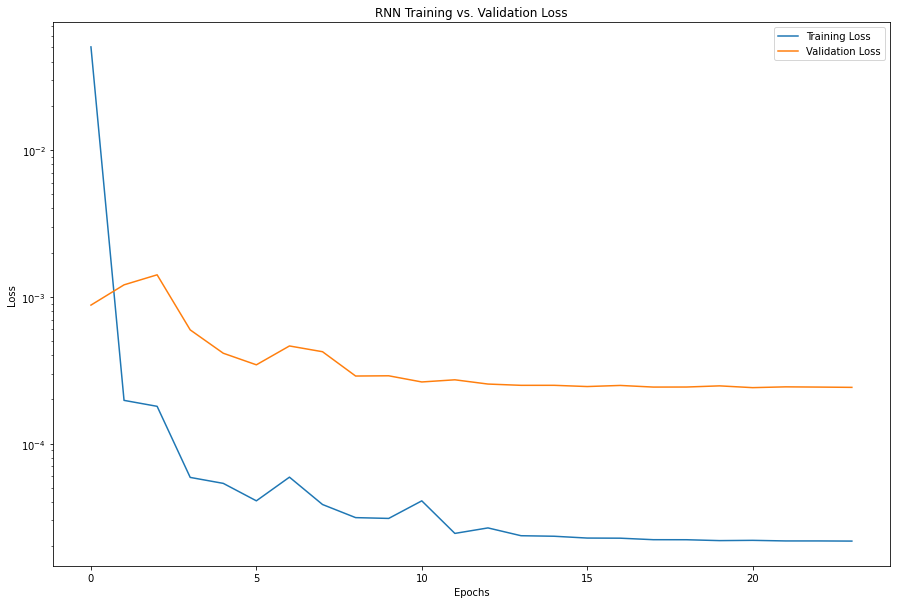

In [28]:
# plotting code with log scale

%matplotlib inline 

plt.figure(figsize=(15, 10))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('RNN Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # Setting the y-axis to logarithmic scale
plt.legend()
plt.show()

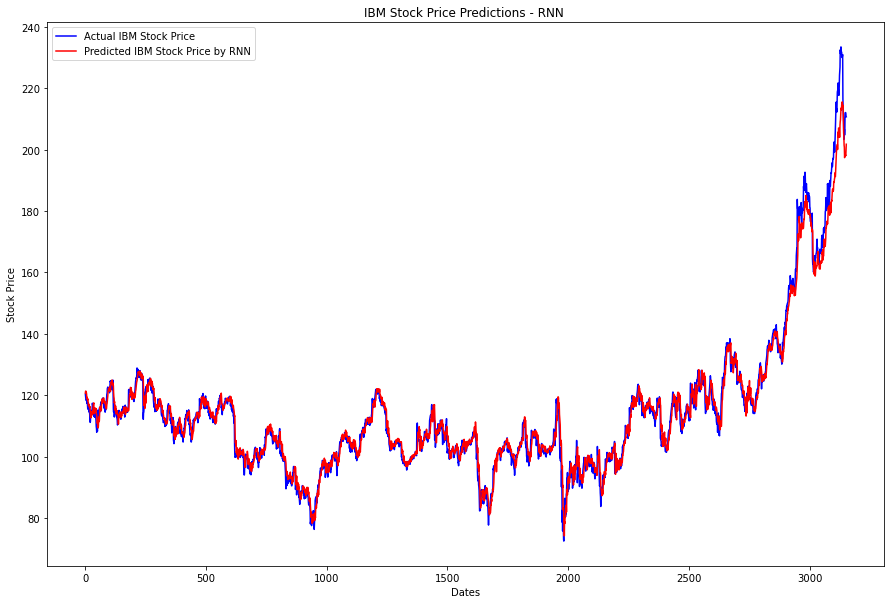

In [29]:
# predicted and actual price plot 

plt.figure(figsize=(15, 10))
plt.plot(actual_prices, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_prices, color="red", label="Predicted IBM Stock Price by RNN")
plt.title("IBM Stock Price Predictions - RNN ")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()